## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import competitions.pascalvoc as comp;

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
# comp.make_metadata_file('2007')
# comp.make_metadata_file('2012')
meta2007 = comp.load_metadata('2007')
meta2012 = comp.load_metadata('2012')
fold2007 = comp.make_2007_fold()
fold2012 = comp.make_2012_fold()
meta = meta2012
fold = fold2012
print("val",len(fold['val']), 'trn',len(fold['trn']), 'tst',len(fold['tst']))

TRAIN_PATH = meta['img_dir']
TEST_PATH = meta['img_dir']

val 5823 trn 5717 tst 0


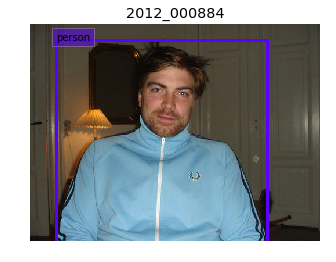

In [8]:
# View images
fpaths,fnames = utils.files.get_paths_to_files(TRAIN_PATH, strip_ext=True)
idx = random.randint(0, len(fpaths))
img = utils.imgs.load_img_as_arr(fpaths[idx])
bboxes= meta['imgs'][fnames[idx]]['bboxes']
title = meta['imgs'][fnames[idx]]['img_id']
utils.imgs.plot_img_w_bboxes(img, bboxes, title)

In [9]:
HARDWARE_CONFIG = {
    'hostname': socket.gethostname(),
    'random_seed': 3,
    'gpu_device':0
}
torch.cuda.set_device(HARDWARE_CONFIG['gpu_device'])
torch.set_default_tensor_type('torch.cuda.FloatTensor')
cudnn.benchmark = True

DATA_CONFIG = {
    'img_rescale': 300,
    'dset_fold': '2007',
    'n_classes': len(cfg.LABEL_NAMES) + 1, #extra background?
    'img_mean': (104, 117, 123)
}

TRAIN_CONFIG = {
    'initial_lr': 1e-3,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'n_epochs': 132, #120K iters
    'n_cycles': 9,
    'early_stop_metric': metric.Loss().name,
    'max_patience': 20,
    'batch_size': 16,
    'threshold': 0.5,
    'save_weights_cadence': 1, #every epoch
    'lr_schedule': {88: 1e-4, 110: 1e-5, 131: 1e-6}
}

OTHER_CONFIG = {}

TRANSFORMS = {
    c.TRAIN: torchsample.transforms.Compose([
        data_aug.SSDAugmentation(DATA_CONFIG['img_rescale'], 
                                 DATA_CONFIG['img_mean'])
    ]),
    c.VAL: torchsample.transforms.Compose([
        data_aug.SSDBaseAugmentation(DATA_CONFIG['img_rescale'], 
                                     DATA_CONFIG['img_mean'])
    ]),
    c.TEST: torchsample.transforms.Compose([
        data_aug.SSDBaseAugmentation(DATA_CONFIG['img_rescale'], 
                                     DATA_CONFIG['img_mean'])
    ]),
    c.TARGET: torchsample.transforms.Compose([
        data_aug.BBoxTransform(cfg.LABEL_TO_IDX)
    ]),
}

## Data

In [10]:
SAMPLE = 10000000
trn_fpaths = data_folds.get_fpaths_from_fold(fold, c.TRAIN, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)[:SAMPLE]
val_fpaths = data_folds.get_fpaths_from_fold(fold, c.VAL, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)[:SAMPLE]
tst_fpaths = data_folds.get_fpaths_from_fold(fold, c.TEST, TEST_PATH, postfix=c.JPG_EXT)

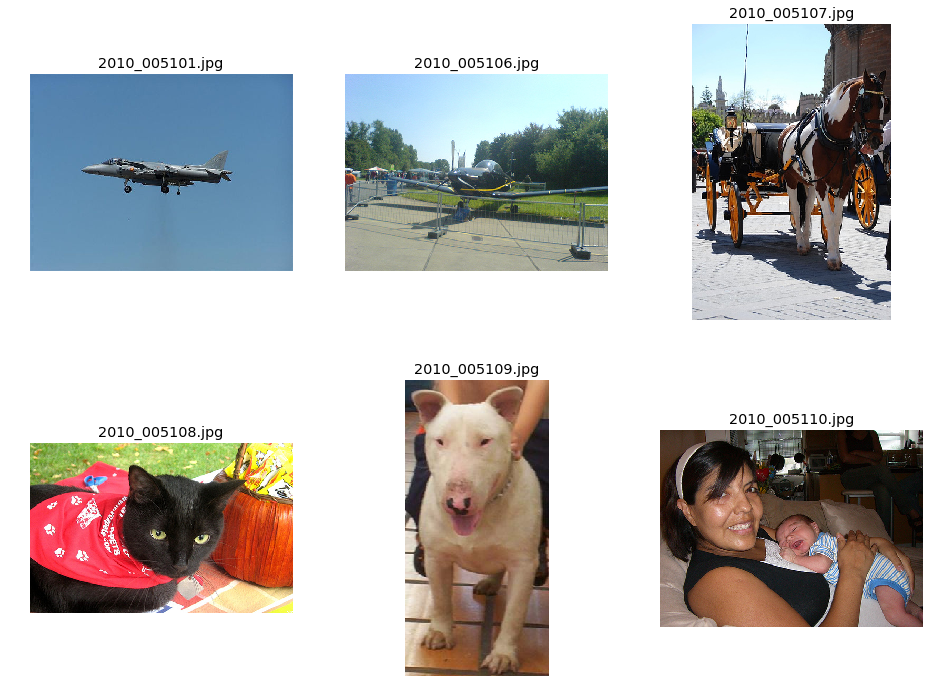

In [11]:
utils.imgs.plot_samples_from_dir(TRAIN_PATH, shuffle=True)

In [12]:
trn_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.TRAIN][:SAMPLE], meta, 
                                                 transform=TRANSFORMS[c.TRAIN], 
                                                 target_transform=TRANSFORMS[c.TARGET])
val_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.VAL][:SAMPLE], meta, 
                                                 transform=TRANSFORMS[c.VAL], 
                                                 target_transform=TRANSFORMS[c.TARGET])
tst_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.TEST], meta, 
                                                 transform=TRANSFORMS[c.TEST], 
                                                 target_transform=TRANSFORMS[c.TARGET])
trn_loader = torch.utils.data.DataLoader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                         shuffle=True, num_workers=4, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                         shuffle=False, num_workers=1, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)
tst_loader = torch.utils.data.DataLoader(tst_dataset, batch_size=1, 
                                         shuffle=False, num_workers=1, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)

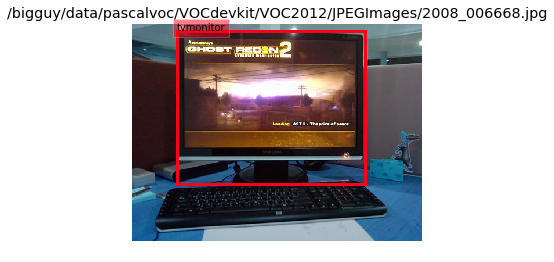

In [13]:
idx = random.randint(0, len(trn_dataset))
utils.imgs.plot_img_w_bboxes(trn_dataset.get_image(idx), 
                             trn_dataset.get_bboxes(idx), 
                             trn_dataset.get_fpath(idx))

In [16]:
from models.ssd import ssd
from models.ssd.multibox_loss import MultiBoxLoss
from models.ssd.detection import Detect

model = ssd.build_ssd('train', DATA_CONFIG['img_rescale'], 
                     DATA_CONFIG['n_classes'])
vgg_weights_fpath = torch.load(os.path.join(
    cfg.PATHS['project'], 'pretrained', 
    'vgg16_reducedfc.pth'))
model.vgg.load_state_dict(vgg_weights_fpath)
model = model.cuda()

model.extras.apply(models.utils.xavier)
model.loc.apply(models.utils.xavier)
model.conf.apply(models.utils.xavier)

optimizer = optim.SGD(model.parameters(), lr=TRAIN_CONFIG['initial_lr'],
                      momentum=TRAIN_CONFIG['momentum'], 
                      weight_decay=TRAIN_CONFIG['weight_decay'])

criterion = MultiBoxLoss(
    DATA_CONFIG['n_classes'], 0.5, True, 
    0, True, 3, 0.5, False, True)

lr_adjuster = learning_rates.ScheduledLR(
    TRAIN_CONFIG['initial_lr'], 'mini_batch', 
    TRAIN_CONFIG['lr_schedule'])

detect = Detect(DATA_CONFIG['n_classes'], bkg_label=0,
                top_k=200, conf_thresh=0.01, nms_thresh=0.45)

In [15]:
# Load pretrained network
model = ssd.build_ssd('train', DATA_CONFIG['img_rescale'], 
                     DATA_CONFIG['n_classes'])
model.load_weights(os.path.join('/bigguy/data/pascalvoc/pretrained', 'ssd300_mAP_77.43_v2.pth'))

Loading weights into state dict...
Finished!


In [17]:
trainer = training.trainers.SSDTrainer(
    criterion, criterion, optimizer, lr_adjuster,
    cfg.IDX_TO_LABEL, detect)

In [11]:
img, targ, dims, idx = next(iter(val_loader))
pred = predictions.bboxes.predict(model, img, dims, detect, thresh=0.6)

In [12]:
preds = predictions.bboxes.get_predictions(model, tst_loader, detect, thresh=0.01)
targs = {id_: meta['imgs'][id_] for id_ in tst_loader.dataset.img_ids}

In [22]:
label_level_metrics = metrics.bboxes.get_bb_label_level_metrics(preds, targs, cfg.LABEL_NAMES, overlap_thresh=0.5)

,ap,fp,iou,total_gt_bbs,tp
aeroplane,0.819920,3953.0,0.805968,285.0,269.0
bicycle,0.856286,3259.0,0.806446,337.0,318.0
bird,0.758060,11673.0,0.777426,459.0,412.0
boat,0.700820,11186.0,0.758705,263.0,235.0
bottle,0.501501,27094.0,0.727034,469.0,373.0
bus,0.847900,3078.0,0.848326,213.0,209.0
car,0.859253,20395.0,0.829694,1201.0,1149.0
cat,0.873588,2384.0,0.839474,358.0,341.0
chair,0.620038,37177.0,0.745044,756.0,679.0
cow,0.827261,1792.0,0.820778,244.0,236.0


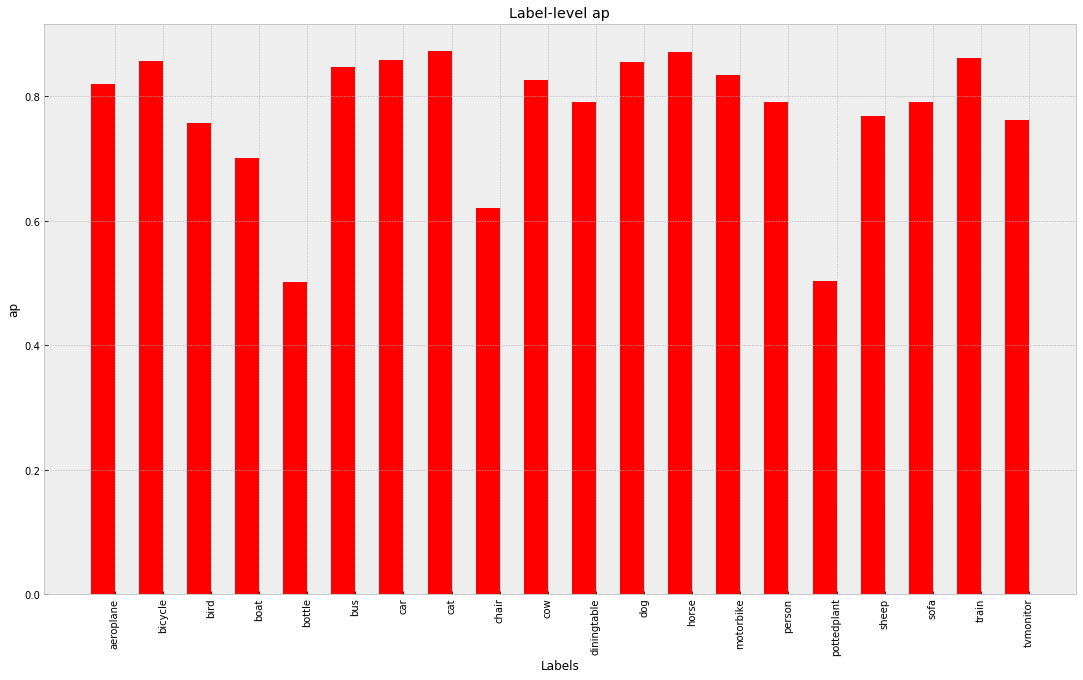

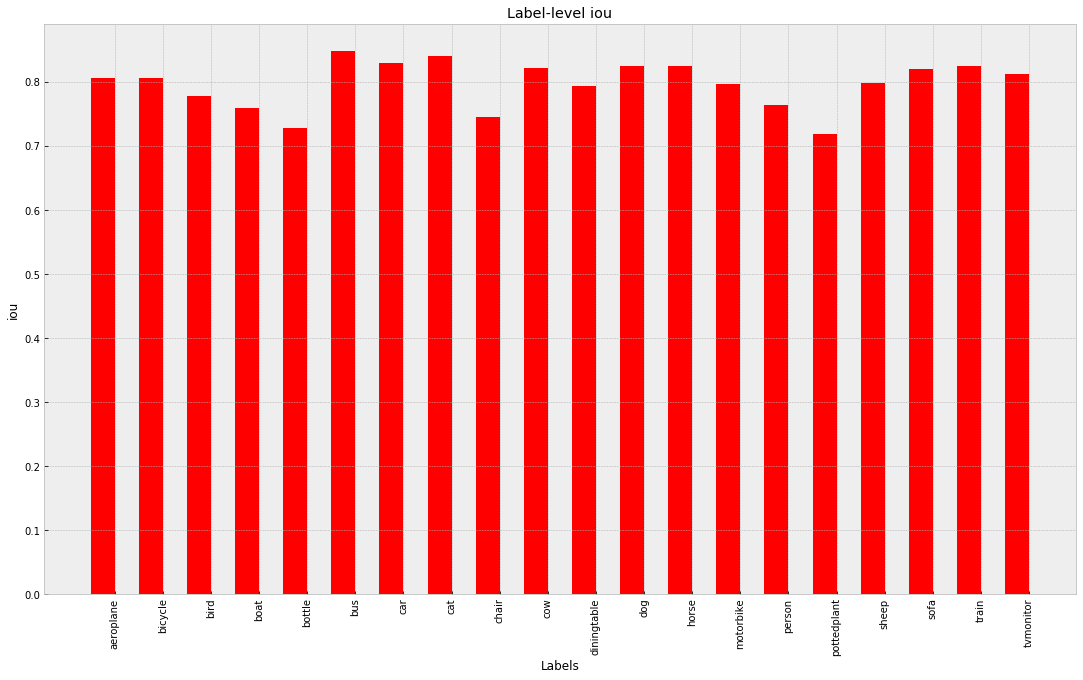

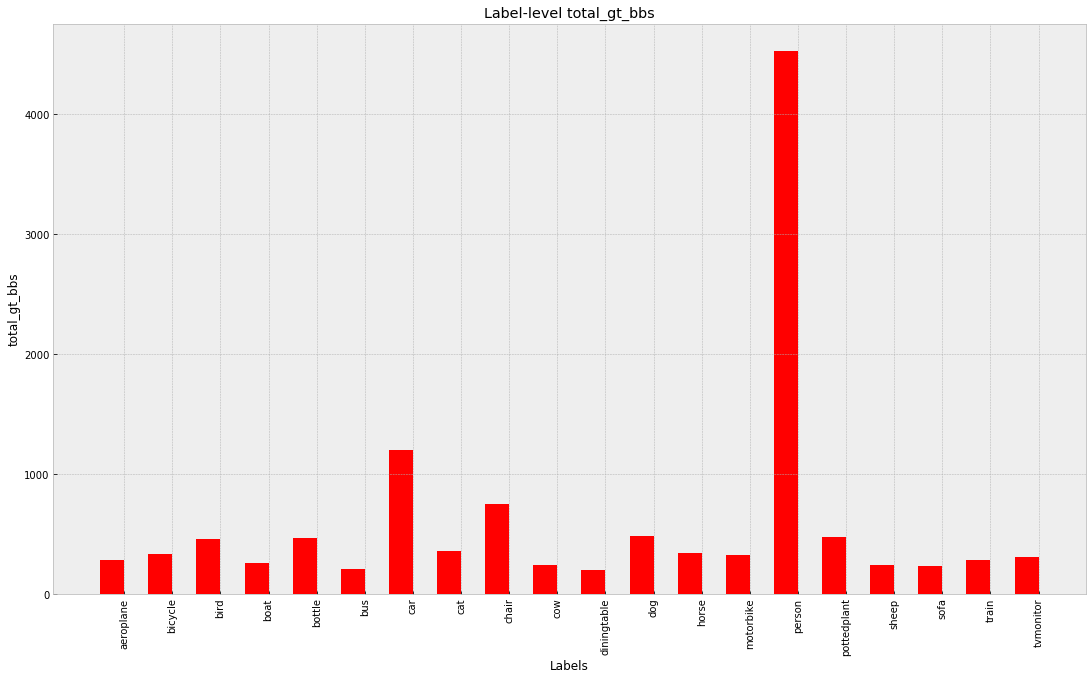

In [23]:
metrics.bboxes.plot_label_level_metric(label_level_metrics, 'ap')
metrics.bboxes.plot_label_level_metric(label_level_metrics, 'iou')
metrics.bboxes.plot_label_level_metric(label_level_metrics, 'total_gt_bbs')
df = metrics.bboxes.get_label_level_bb_metrics(label_level_metrics)
df

In [ ]:
#trainer.test(model, val_loader, TRAIN_CONFIG['threshold'], metrics=[metric.Loss()])
#trainer.train(model, val_loader, TRAIN_CONFIG['threshold'], metrics=[metric.Loss()])

## Train

In [ ]:
# Load existing weights (optional)
experiment_name = 'SSD-SGD-ScheduledLR-img300-lr0.001-wd0.0005-bs16-fold1-idBED91'
epoch = 87
exp_utils.load_weights_by_exp_and_epoch(model, experiment_name, epoch)

In [20]:
# Experiment config
NEW_EXP_NAME = ''
RESUME_EXP_NAME = None#'SSD-SGD-ScheduledLR-img300-lr0.001-wd0.0005-bs16-fold1-idBED91'
if not RESUME_EXP_NAME:
    EXP_NAME_ARGS = [utils.general.get_class_name(model), 
                    utils.general.get_class_name(optimizer), 
                    utils.general.get_class_name(lr_adjuster),
                    'img'+str(DATA_CONFIG['img_rescale']),
                    'lr'+str(TRAIN_CONFIG['initial_lr']),
                    'wd'+str(TRAIN_CONFIG['weight_decay']),
                    'bs'+str(TRAIN_CONFIG['batch_size']),
                    str(DATA_CONFIG['dset_fold'])]
    EXPERIMENT_NAME = exp_utils.generate_display_name(NEW_EXP_NAME, EXP_NAME_ARGS)
    METRICS = [metric.Loss()]#, metric.Accuracy(), metric.F2Score()]
    AUX_METRICS = [metric.AuxiliaryMetric('LearningRate', 'lr'), 
                   metric.AuxiliaryMetric('SystemMemory', 'mb')]
    VISUALIZERS = [Viz(EXPERIMENT_NAME)]

    EXP_CONFIG = {
        'name': EXPERIMENT_NAME,
        'parent_dir': cfg.PATHS['experiments'],
        'metrics': METRICS,
        'aux_metrics': AUX_METRICS,
        'visualizers': VISUALIZERS,
        'data': DATA_CONFIG,
        'training': TRAIN_CONFIG,
        'other': OTHER_CONFIG,
        'transforms': TRANSFORMS[c.TRAIN],
        'hardware': HARDWARE_CONFIG,
        'model': model,
        'optimizer': optimizer,
        'lr_adjuster': lr_adjuster,
        'criterion': criterion
    }

In [ ]:
# Resume experiment
exp = Experiment(RESUME_EXP_NAME, cfg.PATHS['experiments'])
exp.resume(verbose=True)
trainer = training.trainers.SSDTrainer(
    criterion, criterion, optimizer, lr_adjuster,
    cfg.IDX_TO_LABEL, detect)

In [21]:
# Create new experiment
exp = Experiment(EXP_CONFIG['name'], cfg.PATHS['experiments'])
exp.init(EXP_CONFIG)
print(exp.name)

SSD-SGD-ScheduledLR-img300-lr0.001-wd0.0005-bs16-2007-idB8C3E


In [ ]:
exp.train(trainer, trn_loader, val_loader)

/home/bfortuner/anaconda3/lib/python3.6/site-packages/torch/autograd/_functions/tensor.py:450: UserWarning: mask is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return tensor.masked_fill_(mask, value)


iter 10 || Loss: 16.9057
iter 20 || Loss: 15.4519
iter 30 || Loss: 14.8497
iter 40 || Loss: 15.0844
iter 50 || Loss: 12.5715
iter 60 || Loss: 11.1871
iter 70 || Loss: 9.7455
iter 80 || Loss: 8.9690
iter 90 || Loss: 8.6595
iter 100 || Loss: 8.4863
iter 110 || Loss: 8.6534
iter 120 || Loss: 8.6271
iter 130 || Loss: 8.0520
iter 140 || Loss: 8.3639
iter 150 || Loss: 7.8619
iter 160 || Loss: 8.4829
iter 170 || Loss: 8.7328
iter 180 || Loss: 8.2910
iter 190 || Loss: 7.9253
iter 200 || Loss: 8.3539
iter 210 || Loss: 7.3659
iter 220 || Loss: 7.9249
iter 230 || Loss: 8.4659
iter 240 || Loss: 8.4811
iter 250 || Loss: 7.9246
iter 260 || Loss: 7.4476
iter 270 || Loss: 7.3554
iter 280 || Loss: 8.5937
iter 290 || Loss: 7.4545
iter 300 || Loss: 8.0256
iter 310 || Loss: 8.3045
iter 320 || Loss: 8.1034
iter 330 || Loss: 8.5844
iter 340 || Loss: 7.9124
iter 350 || Loss: 8.2300


Epoch 1
Trn - Loss 9.4176 | LR .001 | Time 1.0m 54.75s
Val - Loss 7.8334 | LR .001 | Time 30.0m 14.98s


Memory usage (): 2084.00 MB

iter 360 || Loss: 8.5366
iter 370 || Loss: 8.2347
iter 380 || Loss: 7.7609
iter 390 || Loss: 8.0110
iter 400 || Loss: 7.5095
iter 410 || Loss: 8.0092
iter 420 || Loss: 8.6474
iter 430 || Loss: 7.8453
iter 440 || Loss: 7.7556
iter 450 || Loss: 7.2671
iter 460 || Loss: 8.0990
iter 470 || Loss: 8.2085
iter 480 || Loss: 8.1815
iter 490 || Loss: 8.0923
iter 500 || Loss: 7.3578
iter 510 || Loss: 8.3312
iter 520 || Loss: 8.3078
iter 530 || Loss: 8.1341
iter 540 || Loss: 8.2740
iter 550 || Loss: 7.8385
iter 560 || Loss: 8.0922
iter 570 || Loss: 7.6149
iter 580 || Loss: 8.0421
iter 590 || Loss: 8.1540
iter 600 || Loss: 9.0349
iter 610 || Loss: 7.7155
iter 620 || Loss: 7.8398
iter 630 || Loss: 8.2343
iter 640 || Loss: 7.6469
iter 650 || Loss: 8.3032
iter 660 || Loss: 8.2117
iter 670 || Loss: 8.0492
iter 680 || Loss: 8.0803
iter 690 || Loss: 7.9825
iter 700 || Loss: 8.0949
iter 710 || Loss: 8.1974


Epoch 2
Trn - Loss 8.0287 | LR .000001 | Time 1.0m 49.78s
Val - Loss 7.7996 | LR .000001 | Time 31.0m 13.59s


Memory usage (): 2119.00 MB

iter 720 || Loss: 7.8861
iter 730 || Loss: 7.8495
iter 740 || Loss: 7.7030
iter 750 || Loss: 7.8278
iter 760 || Loss: 7.8566
iter 770 || Loss: 8.3690
iter 780 || Loss: 7.7729
iter 790 || Loss: 7.9084
iter 800 || Loss: 7.8762
iter 810 || Loss: 8.7395
iter 820 || Loss: 8.0566
iter 830 || Loss: 7.7649
iter 840 || Loss: 8.3848
iter 850 || Loss: 8.1087
iter 860 || Loss: 8.0866
iter 870 || Loss: 7.3685
iter 880 || Loss: 7.7702
iter 890 || Loss: 7.6791
iter 900 || Loss: 8.1783
iter 910 || Loss: 7.9894
iter 920 || Loss: 8.0440
iter 930 || Loss: 8.5221
iter 940 || Loss: 8.7017
iter 950 || Loss: 7.7669
iter 960 || Loss: 7.8379
iter 970 || Loss: 7.8550
iter 980 || Loss: 8.6697
iter 990 || Loss: 8.1892
iter 1000 || Loss: 7.9011
iter 1010 || Loss: 7.8771
iter 1020 || Loss: 7.5082
iter 1030 || Loss: 7.4949
iter 1040 || Loss: 8.0837
iter 1050 || Loss: 8.4652
iter 1060 || Loss: 8.0361
iter 1070 || Loss: 7.7641


Epoch 3
Trn - Loss 8.0015 | LR .000001 | Time 1.0m 49.78s
Val - Loss 7.7743 | LR .000001 | Time 31.0m 53.02s


Memory usage (): 2119.00 MB

iter 1080 || Loss: 8.4755
iter 1090 || Loss: 7.9511
iter 1100 || Loss: 7.4987
iter 1110 || Loss: 7.9445
iter 1120 || Loss: 8.1998
iter 1130 || Loss: 7.6967
iter 1140 || Loss: 7.7276
iter 1150 || Loss: 8.1044
iter 1160 || Loss: 7.7852
iter 1170 || Loss: 8.3315
iter 1180 || Loss: 7.6174
iter 1190 || Loss: 8.1624
iter 1200 || Loss: 8.5702
iter 1210 || Loss: 8.0309
iter 1220 || Loss: 7.9555
iter 1230 || Loss: 7.8368
iter 1240 || Loss: 8.2246
iter 1250 || Loss: 8.0187
iter 1260 || Loss: 8.6721
iter 1270 || Loss: 8.0289
iter 1280 || Loss: 8.0406
iter 1290 || Loss: 8.0323
iter 1300 || Loss: 9.4027
iter 1310 || Loss: 8.0754
iter 1320 || Loss: 8.2294
iter 1330 || Loss: 8.3273
iter 1340 || Loss: 8.3169
iter 1350 || Loss: 7.8985
iter 1360 || Loss: 7.8992
iter 1370 || Loss: 7.4351
iter 1380 || Loss: 7.7820
iter 1390 || Loss: 7.3174
iter 1400 || Loss: 7.9440
iter 1410 || Loss: 7.8203
iter 1420 || Loss: 7.7925
iter 1430 || Loss: 8.4468


Epoch 4
Trn - Loss 7.9758 | LR .000001 | Time 1.0m 49.82s
Val - Loss 7.7508 | LR .000001 | Time 32.0m 25.32s


Memory usage (): 2119.00 MB

iter 1440 || Loss: 8.3046
iter 1450 || Loss: 8.0025
iter 1460 || Loss: 8.0937
iter 1470 || Loss: 8.2811
iter 1480 || Loss: 7.8578
iter 1490 || Loss: 7.7434
iter 1500 || Loss: 8.4154
iter 1510 || Loss: 7.0929
iter 1520 || Loss: 7.6873
iter 1530 || Loss: 7.7321
iter 1540 || Loss: 8.0885
iter 1550 || Loss: 8.2099
iter 1560 || Loss: 8.7969
iter 1570 || Loss: 7.7121
iter 1580 || Loss: 7.4868
iter 1590 || Loss: 8.1905
iter 1600 || Loss: 7.9168
iter 1610 || Loss: 8.0606
iter 1620 || Loss: 8.1104
iter 1630 || Loss: 8.0624
iter 1640 || Loss: 7.6339
iter 1650 || Loss: 7.8949
iter 1660 || Loss: 7.7734
iter 1670 || Loss: 8.3556
iter 1680 || Loss: 8.3656
iter 1690 || Loss: 8.3889
iter 1700 || Loss: 7.9669
iter 1710 || Loss: 7.9129
iter 1720 || Loss: 8.4899
iter 1730 || Loss: 8.0894
iter 1740 || Loss: 7.7654
iter 1750 || Loss: 7.9321
iter 1760 || Loss: 7.6332
iter 1770 || Loss: 7.9971
iter 1780 || Loss: 7.6471


Epoch 5
Trn - Loss 7.9404 | LR .000001 | Time 1.0m 49.80s


iter 1790 || Loss: 8.3407


Val - Loss 7.7321 | LR .000001 | Time 32.0m 40.69s


Memory usage (): 2119.00 MB

iter 1800 || Loss: 7.8920
iter 1810 || Loss: 8.1898
iter 1820 || Loss: 7.6639
iter 1830 || Loss: 8.2663
iter 1840 || Loss: 7.8722
iter 1850 || Loss: 7.5506
iter 1860 || Loss: 7.2891
iter 1870 || Loss: 7.7447
iter 1880 || Loss: 8.3414
iter 1890 || Loss: 7.8067
iter 1900 || Loss: 8.2312
iter 1910 || Loss: 7.8847
iter 1920 || Loss: 8.0519
iter 1930 || Loss: 7.9883
iter 1940 || Loss: 8.2177
iter 1950 || Loss: 7.7264
iter 1960 || Loss: 7.5071
iter 1970 || Loss: 7.6891
iter 1980 || Loss: 8.0803
iter 1990 || Loss: 8.0771
iter 2000 || Loss: 7.7609
iter 2010 || Loss: 7.7149
iter 2020 || Loss: 8.0040
iter 2030 || Loss: 7.8298
iter 2040 || Loss: 8.0848
iter 2050 || Loss: 7.5161
iter 2060 || Loss: 7.9485
iter 2070 || Loss: 8.0228
iter 2080 || Loss: 7.4206
iter 2090 || Loss: 7.3591
iter 2100 || Loss: 7.8242
iter 2110 || Loss: 7.6324
iter 2120 || Loss: 7.5715
iter 2130 || Loss: 8.3956
iter 2140 || Loss: 7.9186


Epoch 6
Trn - Loss 7.9166 | LR .000001 | Time 1.0m 49.74s
Val - Loss 7.7135 | LR .000001 | Time 32.0m 58.08s


Memory usage (): 2119.00 MB

iter 2150 || Loss: 8.0539
iter 2160 || Loss: 7.3760
iter 2170 || Loss: 7.5871
iter 2180 || Loss: 7.8699
iter 2190 || Loss: 7.6093
iter 2200 || Loss: 7.8586
iter 2210 || Loss: 7.2514
iter 2220 || Loss: 7.8186
iter 2230 || Loss: 7.9782
iter 2240 || Loss: 7.6532
iter 2250 || Loss: 7.7828
iter 2260 || Loss: 7.4069
iter 2270 || Loss: 7.9929
iter 2280 || Loss: 7.8619
iter 2290 || Loss: 7.3825
iter 2300 || Loss: 7.6633
iter 2310 || Loss: 7.9359
iter 2320 || Loss: 7.4864
iter 2330 || Loss: 7.4113
iter 2340 || Loss: 7.6443
iter 2350 || Loss: 8.2309
iter 2360 || Loss: 8.0851
iter 2370 || Loss: 7.3253
iter 2380 || Loss: 7.6099
iter 2390 || Loss: 8.2239
iter 2400 || Loss: 8.1255
iter 2410 || Loss: 7.3016
iter 2420 || Loss: 8.1289
iter 2430 || Loss: 7.6481
iter 2440 || Loss: 7.8038
iter 2450 || Loss: 7.7543
iter 2460 || Loss: 7.2296
iter 2470 || Loss: 7.4602
iter 2480 || Loss: 8.0782
iter 2490 || Loss: 8.1437
iter 2500 || Loss: 7.4598


Epoch 7
Trn - Loss 7.8950 | LR .000001 | Time 1.0m 49.80s
Val - Loss 7.6975 | LR .000001 | Time 33.0m 13.16s


Memory usage (): 2119.00 MB

iter 2510 || Loss: 8.2655
iter 2520 || Loss: 7.6109
iter 2530 || Loss: 7.5465
iter 2540 || Loss: 7.6595
iter 2550 || Loss: 7.8285
iter 2560 || Loss: 7.7017
iter 2570 || Loss: 7.9016
iter 2580 || Loss: 7.5512
iter 2590 || Loss: 8.3305
iter 2600 || Loss: 7.8368
iter 2610 || Loss: 7.8392
iter 2620 || Loss: 8.1188
iter 2630 || Loss: 7.5630
iter 2640 || Loss: 8.0013
iter 2650 || Loss: 7.5911
iter 2660 || Loss: 8.3035
iter 2670 || Loss: 7.9627
iter 2680 || Loss: 8.1305
iter 2690 || Loss: 8.4593
iter 2700 || Loss: 8.0357
iter 2710 || Loss: 8.3599
iter 2720 || Loss: 7.8148
iter 2730 || Loss: 8.0412
iter 2740 || Loss: 8.0722
iter 2750 || Loss: 7.8332
iter 2760 || Loss: 7.3059
iter 2770 || Loss: 8.2317
iter 2780 || Loss: 7.6301
iter 2790 || Loss: 7.9714
iter 2800 || Loss: 8.3000
iter 2810 || Loss: 7.9780
iter 2820 || Loss: 8.2180
iter 2830 || Loss: 7.9481
iter 2840 || Loss: 7.6914
iter 2850 || Loss: 8.0921
iter 2860 || Loss: 8.0822


Epoch 8
Trn - Loss 7.8926 | LR .000001 | Time 1.0m 49.68s
Val - Loss 7.6830 | LR .000001 | Time 33.0m 24.22s


Memory usage (): 2119.00 MB

iter 2870 || Loss: 7.9597
iter 2880 || Loss: 7.7953
iter 2890 || Loss: 8.0471
iter 2900 || Loss: 7.8775
iter 2910 || Loss: 7.9581
iter 2920 || Loss: 8.4605
iter 2930 || Loss: 7.7023
iter 2940 || Loss: 7.9635
iter 2950 || Loss: 7.9628
iter 2960 || Loss: 8.0281
iter 2970 || Loss: 8.4048
iter 2980 || Loss: 8.4284
iter 2990 || Loss: 7.6571
iter 3000 || Loss: 7.7234
iter 3010 || Loss: 7.3769
iter 3020 || Loss: 7.4980
iter 3030 || Loss: 8.0941
iter 3040 || Loss: 9.2877
iter 3050 || Loss: 7.8236
iter 3060 || Loss: 7.2710
iter 3070 || Loss: 7.4507
iter 3080 || Loss: 7.4051
iter 3090 || Loss: 8.1779
iter 3100 || Loss: 7.8350
iter 3110 || Loss: 7.9652
iter 3120 || Loss: 7.9697
iter 3130 || Loss: 7.7821
iter 3140 || Loss: 7.8979
iter 3150 || Loss: 7.3400
iter 3160 || Loss: 8.3718
iter 3170 || Loss: 7.5052
iter 3180 || Loss: 8.1273
iter 3190 || Loss: 7.1608
iter 3200 || Loss: 7.9158
iter 3210 || Loss: 7.6811
iter 3220 || Loss: 7.7322


Epoch 9
Trn - Loss 7.8567 | LR .000001 | Time 1.0m 49.51s
Val - Loss 7.6685 | LR .000001 | Time 33.0m 31.99s


Memory usage (): 2120.00 MB

iter 3230 || Loss: 8.4016
iter 3240 || Loss: 7.8242
iter 3250 || Loss: 7.6011
iter 3260 || Loss: 7.7434
iter 3270 || Loss: 8.0396
iter 3280 || Loss: 7.8414
iter 3290 || Loss: 8.0433
iter 3300 || Loss: 7.6129
iter 3310 || Loss: 7.7258
iter 3320 || Loss: 8.1159
iter 3330 || Loss: 7.6684
iter 3340 || Loss: 8.1992
iter 3350 || Loss: 8.5012
iter 3360 || Loss: 8.2973
iter 3370 || Loss: 7.8417
iter 3380 || Loss: 7.9727
iter 3390 || Loss: 8.1679
iter 3400 || Loss: 8.3213
iter 3410 || Loss: 7.6850
iter 3420 || Loss: 8.1027
iter 3430 || Loss: 7.8030
iter 3440 || Loss: 8.3113
iter 3450 || Loss: 8.1205
iter 3460 || Loss: 7.7661
iter 3470 || Loss: 7.6204
iter 3480 || Loss: 7.9467
iter 3490 || Loss: 7.9455
iter 3500 || Loss: 7.6803
iter 3510 || Loss: 7.4920
iter 3520 || Loss: 8.2378
iter 3530 || Loss: 8.1706
iter 3540 || Loss: 8.5807
iter 3550 || Loss: 7.9155
iter 3560 || Loss: 7.5275
iter 3570 || Loss: 8.0500


Epoch 10
Trn - Loss 7.8498 | LR .000001 | Time 1.0m 49.56s


iter 3580 || Loss: 8.2995


Val - Loss 7.6565 | LR .000001 | Time 33.0m 40.30s


Memory usage (): 2122.00 MB

iter 3590 || Loss: 7.8273
iter 3600 || Loss: 7.9283
iter 3610 || Loss: 7.5571
iter 3620 || Loss: 7.2928
iter 3630 || Loss: 7.4838
iter 3640 || Loss: 7.8117
iter 3650 || Loss: 7.4850
iter 3660 || Loss: 7.7701
iter 3670 || Loss: 7.8389
iter 3680 || Loss: 7.8711
iter 3690 || Loss: 8.0016
iter 3700 || Loss: 8.0142
iter 3710 || Loss: 7.9617
iter 3720 || Loss: 7.9165
iter 3730 || Loss: 7.2033
iter 3740 || Loss: 7.4628
iter 3750 || Loss: 7.5159
iter 3760 || Loss: 8.1632
iter 3770 || Loss: 7.8830
iter 3780 || Loss: 7.2563
iter 3790 || Loss: 8.0736
iter 3800 || Loss: 7.8616
iter 3810 || Loss: 8.0561
iter 3820 || Loss: 7.9138
iter 3830 || Loss: 8.2396
iter 3840 || Loss: 7.4975
iter 3850 || Loss: 8.3831
iter 3860 || Loss: 7.5338
iter 3870 || Loss: 8.0897
iter 3880 || Loss: 8.3172
iter 3890 || Loss: 8.0407
iter 3900 || Loss: 7.6832
iter 3910 || Loss: 7.3598
iter 3920 || Loss: 7.5715
iter 3930 || Loss: 7.7288


Epoch 11
Trn - Loss 7.8361 | LR .000001 | Time 1.0m 49.62s
Val - Loss 7.6450 | LR .000001 | Time 33.0m 51.93s


Memory usage (): 2124.00 MB

iter 3940 || Loss: 7.8402
iter 3950 || Loss: 7.7583
iter 3960 || Loss: 8.1353
iter 3970 || Loss: 8.0086
iter 3980 || Loss: 7.2110
iter 3990 || Loss: 8.1028
iter 4000 || Loss: 7.7884
iter 4010 || Loss: 7.8341
iter 4020 || Loss: 7.6084
iter 4030 || Loss: 7.7953
iter 4040 || Loss: 7.8952
iter 4050 || Loss: 8.2520
iter 4060 || Loss: 8.0455
iter 4070 || Loss: 7.8763
iter 4080 || Loss: 8.0844
iter 4090 || Loss: 7.4959
iter 4100 || Loss: 7.9456
iter 4110 || Loss: 7.6546
iter 4120 || Loss: 7.9318
iter 4130 || Loss: 7.6596
iter 4140 || Loss: 6.9513
iter 4150 || Loss: 7.0384
iter 4160 || Loss: 7.8870
iter 4170 || Loss: 8.3425
iter 4180 || Loss: 7.5599
iter 4190 || Loss: 7.8115
iter 4200 || Loss: 7.7518
iter 4210 || Loss: 7.5978
iter 4220 || Loss: 7.4481
iter 4230 || Loss: 8.0890
iter 4240 || Loss: 7.9740
iter 4250 || Loss: 8.0053
iter 4260 || Loss: 8.1253
iter 4270 || Loss: 8.2904
iter 4280 || Loss: 7.7400
iter 4290 || Loss: 7.6147


Epoch 12
Trn - Loss 7.8415 | LR .000001 | Time 1.0m 49.62s
Val - Loss 7.6338 | LR .000001 | Time 33.0m 57.85s


Memory usage (): 2126.00 MB

iter 4300 || Loss: 7.9298
iter 4310 || Loss: 7.6452
iter 4320 || Loss: 7.7128
iter 4330 || Loss: 8.2282
iter 4340 || Loss: 7.7626
iter 4350 || Loss: 8.3484
iter 4360 || Loss: 7.6180
iter 4370 || Loss: 8.1696
iter 4380 || Loss: 7.7584
iter 4390 || Loss: 7.5716
iter 4400 || Loss: 8.2223
iter 4410 || Loss: 7.1594
iter 4420 || Loss: 8.1716
iter 4430 || Loss: 7.8288
iter 4440 || Loss: 7.8391
iter 4450 || Loss: 7.3800
iter 4460 || Loss: 8.4617
iter 4470 || Loss: 7.3554
iter 4480 || Loss: 8.0129
iter 4490 || Loss: 8.3952
iter 4500 || Loss: 7.0245
iter 4510 || Loss: 8.2121
iter 4520 || Loss: 7.8272
iter 4530 || Loss: 7.9684
iter 4540 || Loss: 7.3047
iter 4550 || Loss: 7.3500
iter 4560 || Loss: 7.6830
iter 4570 || Loss: 7.7635
iter 4580 || Loss: 8.8643
iter 4590 || Loss: 7.7359
iter 4600 || Loss: 7.7523
iter 4610 || Loss: 7.7024
iter 4620 || Loss: 7.9269
iter 4630 || Loss: 7.9536
iter 4640 || Loss: 7.7413
iter 4650 || Loss: 7.7390


Epoch 13
Trn - Loss 7.8107 | LR .000001 | Time 1.0m 49.51s
Val - Loss 7.6234 | LR .000001 | Time 33.0m 56.69s


Memory usage (): 2129.00 MB

iter 4660 || Loss: 8.3448
iter 4670 || Loss: 7.1921
iter 4680 || Loss: 7.8443
iter 4690 || Loss: 8.0832
iter 4700 || Loss: 8.0841
iter 4710 || Loss: 7.5282
iter 4720 || Loss: 7.7985
iter 4730 || Loss: 7.4529
iter 4740 || Loss: 8.0018
iter 4750 || Loss: 7.4735
iter 4760 || Loss: 7.5260
iter 4770 || Loss: 7.5708
iter 4780 || Loss: 7.5701
iter 4790 || Loss: 7.7822
iter 4800 || Loss: 7.7215
iter 4810 || Loss: 8.2149
iter 4820 || Loss: 7.6097
iter 4830 || Loss: 7.7695
iter 4840 || Loss: 8.7585
iter 4850 || Loss: 7.6183
iter 4860 || Loss: 7.7956
iter 4870 || Loss: 7.5199
iter 4880 || Loss: 7.7827
iter 4890 || Loss: 7.5322
iter 4900 || Loss: 7.8486
iter 4910 || Loss: 7.4488
iter 4920 || Loss: 7.7963
iter 4930 || Loss: 8.0562
iter 4940 || Loss: 7.8940
iter 4950 || Loss: 7.2177
iter 4960 || Loss: 8.0236
iter 4970 || Loss: 7.6568
iter 4980 || Loss: 8.2213
iter 4990 || Loss: 7.5146
iter 5000 || Loss: 7.3953
iter 5010 || Loss: 7.3895


Epoch 14
Trn - Loss 7.8115 | LR .000001 | Time 1.0m 49.51s
Val - Loss 7.6144 | LR .000001 | Time 33.0m 55.94s


Memory usage (): 2131.00 MB

iter 5020 || Loss: 7.8861
iter 5030 || Loss: 7.6202
iter 5040 || Loss: 7.4204
iter 5050 || Loss: 8.2133
iter 5060 || Loss: 8.3282
iter 5070 || Loss: 7.6695
iter 5080 || Loss: 7.4874
iter 5090 || Loss: 7.4032
iter 5100 || Loss: 7.4144
iter 5110 || Loss: 7.9729
iter 5120 || Loss: 7.7822
iter 5130 || Loss: 8.2454
iter 5140 || Loss: 7.8757
iter 5150 || Loss: 7.5113
iter 5160 || Loss: 7.8968
iter 5170 || Loss: 7.5949
iter 5180 || Loss: 7.8135
iter 5190 || Loss: 7.9948
iter 5200 || Loss: 7.6828
iter 5210 || Loss: 8.2668
iter 5220 || Loss: 7.6618
iter 5230 || Loss: 7.9050
iter 5240 || Loss: 7.7463
iter 5250 || Loss: 7.2198
iter 5260 || Loss: 7.3685
iter 5270 || Loss: 7.3723
iter 5280 || Loss: 7.7339
iter 5290 || Loss: 7.9268
iter 5300 || Loss: 8.2107
iter 5310 || Loss: 7.5818
iter 5320 || Loss: 7.7475
iter 5330 || Loss: 7.5298
iter 5340 || Loss: 7.5468
iter 5350 || Loss: 7.7282
iter 5360 || Loss: 7.3032


Epoch 15
Trn - Loss 7.7761 | LR .000001 | Time 1.0m 49.49s


iter 5370 || Loss: 8.4680


Val - Loss 7.6054 | LR .000001 | Time 33.0m 53.46s


Memory usage (): 2133.00 MB

iter 5380 || Loss: 8.0953
iter 5390 || Loss: 7.3870
iter 5400 || Loss: 8.0270
iter 5410 || Loss: 8.2673
iter 5420 || Loss: 7.9614
iter 5430 || Loss: 7.9064
iter 5440 || Loss: 7.6466
iter 5450 || Loss: 7.2535
iter 5460 || Loss: 7.9916
iter 5470 || Loss: 7.5146
iter 5480 || Loss: 7.8761
iter 5490 || Loss: 8.2560
iter 5500 || Loss: 8.0061
iter 5510 || Loss: 7.0058
iter 5520 || Loss: 7.7987
iter 5530 || Loss: 8.0011
iter 5540 || Loss: 7.2318
iter 5550 || Loss: 7.5229
iter 5560 || Loss: 8.2619
iter 5570 || Loss: 7.4668
iter 5580 || Loss: 8.2641
iter 5590 || Loss: 8.0757
iter 5600 || Loss: 7.7365
iter 5610 || Loss: 7.6927
iter 5620 || Loss: 7.7484
iter 5630 || Loss: 7.4537
iter 5640 || Loss: 8.1869
iter 5650 || Loss: 7.6157
iter 5660 || Loss: 7.7725
iter 5670 || Loss: 8.0366
iter 5680 || Loss: 7.9063
iter 5690 || Loss: 7.2559
iter 5700 || Loss: 7.2622
iter 5710 || Loss: 7.7641
iter 5720 || Loss: 8.1534


Epoch 16
Trn - Loss 7.7676 | LR .000001 | Time 1.0m 49.57s
Val - Loss 7.5968 | LR .000001 | Time 33.0m 44.92s


Memory usage (): 2136.00 MB

iter 5730 || Loss: 7.8036
iter 5740 || Loss: 7.9883
iter 5750 || Loss: 8.3882
iter 5760 || Loss: 7.7185
iter 5770 || Loss: 7.8339
iter 5780 || Loss: 8.1317
iter 5790 || Loss: 7.6368
iter 5800 || Loss: 7.1290
iter 5810 || Loss: 7.3229
iter 5820 || Loss: 8.0304
iter 5830 || Loss: 8.3117
iter 5840 || Loss: 8.3849
iter 5850 || Loss: 8.3853
iter 5860 || Loss: 7.9319
iter 5870 || Loss: 7.5167
iter 5880 || Loss: 8.7377
iter 5890 || Loss: 8.3023
iter 5900 || Loss: 7.4677
iter 5910 || Loss: 7.6508
iter 5920 || Loss: 8.3468
iter 5930 || Loss: 8.4379
iter 5940 || Loss: 8.1075
iter 5950 || Loss: 7.6549
iter 5960 || Loss: 7.7998
iter 5970 || Loss: 7.3013
iter 5980 || Loss: 7.1387
iter 5990 || Loss: 7.8358
iter 6000 || Loss: 7.7262
iter 6010 || Loss: 7.2915
iter 6020 || Loss: 8.0031
iter 6030 || Loss: 7.5658
iter 6040 || Loss: 7.6084
iter 6050 || Loss: 7.8552
iter 6060 || Loss: 8.0021
iter 6070 || Loss: 7.4784
iter 6080 || Loss: 7.5934


Epoch 17
Trn - Loss 7.7675 | LR .000001 | Time 1.0m 49.46s
Val - Loss 7.5888 | LR .000001 | Time 33.0m 59.64s


Memory usage (): 2138.00 MB

iter 6090 || Loss: 8.4191
iter 6100 || Loss: 7.5609
iter 6110 || Loss: 7.9535
iter 6120 || Loss: 7.5216
iter 6130 || Loss: 7.7420
iter 6140 || Loss: 7.5587
iter 6150 || Loss: 7.7102
iter 6160 || Loss: 7.9934
iter 6170 || Loss: 7.7598
iter 6180 || Loss: 7.4057
iter 6190 || Loss: 7.7888
iter 6200 || Loss: 7.4216
iter 6210 || Loss: 7.4396
iter 6220 || Loss: 7.1006
iter 6230 || Loss: 7.9976
iter 6240 || Loss: 7.8838
iter 6250 || Loss: 8.3375
iter 6260 || Loss: 8.1353
iter 6270 || Loss: 8.2515
iter 6280 || Loss: 7.3798
iter 6290 || Loss: 7.9883
iter 6300 || Loss: 7.7678
iter 6310 || Loss: 7.7362
iter 6320 || Loss: 7.3116
iter 6330 || Loss: 8.1054
iter 6340 || Loss: 7.9122
iter 6350 || Loss: 7.8909
iter 6360 || Loss: 7.4188
iter 6370 || Loss: 7.6456
iter 6380 || Loss: 7.8915
iter 6390 || Loss: 8.1577
iter 6400 || Loss: 7.4096
iter 6410 || Loss: 7.5696
iter 6420 || Loss: 7.9854
iter 6430 || Loss: 7.6762
iter 6440 || Loss: 7.9998


Epoch 18
Trn - Loss 7.7674 | LR .000001 | Time 1.0m 49.43s
Val - Loss 7.5811 | LR .000001 | Time 33.0m 56.75s


Memory usage (): 2141.00 MB

iter 6450 || Loss: 7.6373
iter 6460 || Loss: 7.4549
iter 6470 || Loss: 7.5006
iter 6480 || Loss: 8.2314
iter 6490 || Loss: 7.4887
iter 6500 || Loss: 7.0790
iter 6510 || Loss: 7.8018
iter 6520 || Loss: 7.7465
iter 6530 || Loss: 7.2748
iter 6540 || Loss: 7.7611
iter 6550 || Loss: 7.9874
iter 6560 || Loss: 7.3679
iter 6570 || Loss: 7.9490
iter 6580 || Loss: 7.5227
iter 6590 || Loss: 7.6785
iter 6600 || Loss: 7.9313
iter 6610 || Loss: 7.9815
iter 6620 || Loss: 7.6243
iter 6630 || Loss: 7.4091
iter 6640 || Loss: 7.7402
iter 6650 || Loss: 7.6336
iter 6660 || Loss: 7.3460
iter 6670 || Loss: 7.9305
iter 6680 || Loss: 8.2516
iter 6690 || Loss: 7.5332
iter 6700 || Loss: 7.4655
iter 6710 || Loss: 7.6611
iter 6720 || Loss: 7.7021
iter 6730 || Loss: 8.1991
iter 6740 || Loss: 8.0292
iter 6750 || Loss: 7.5223
iter 6760 || Loss: 7.8745
iter 6770 || Loss: 7.4033
iter 6780 || Loss: 7.5011
iter 6790 || Loss: 7.8910
iter 6800 || Loss: 8.2102


Epoch 19
Trn - Loss 7.7374 | LR .000001 | Time 1.0m 49.64s
Val - Loss 7.5732 | LR .000001 | Time 33.0m 43.73s


Memory usage (): 2143.00 MB

iter 6810 || Loss: 8.2214
iter 6820 || Loss: 8.0103
iter 6830 || Loss: 7.7634
iter 6840 || Loss: 7.3272
iter 6850 || Loss: 8.3726
iter 6860 || Loss: 7.5948
iter 6870 || Loss: 7.4736
iter 6880 || Loss: 7.8811
iter 6890 || Loss: 7.9843
iter 6900 || Loss: 8.4146
iter 6910 || Loss: 7.4639
iter 6920 || Loss: 7.5178
iter 6930 || Loss: 6.9541
iter 6940 || Loss: 7.2732
iter 6950 || Loss: 7.3091
iter 6960 || Loss: 7.9884
iter 6970 || Loss: 7.7928
iter 6980 || Loss: 7.8275
iter 6990 || Loss: 7.6477
iter 7000 || Loss: 7.5249
iter 7010 || Loss: 7.4802
iter 7020 || Loss: 8.1227
iter 7030 || Loss: 7.1174
iter 7040 || Loss: 7.9150
iter 7050 || Loss: 7.8003
iter 7060 || Loss: 7.4017
iter 7070 || Loss: 7.8859
iter 7080 || Loss: 8.1994
iter 7090 || Loss: 7.4977
iter 7100 || Loss: 8.0402
iter 7110 || Loss: 7.6417
iter 7120 || Loss: 7.6990
iter 7130 || Loss: 7.2936
iter 7140 || Loss: 7.4839
iter 7150 || Loss: 7.8123


Epoch 20
Trn - Loss 7.7312 | LR .000001 | Time 1.0m 49.45s


iter 7160 || Loss: 7.9791


Val - Loss 7.5658 | LR .000001 | Time 33.0m 45.90s


Memory usage (): 2145.00 MB

iter 7170 || Loss: 7.3171
iter 7180 || Loss: 7.4600
iter 7190 || Loss: 8.0072
iter 7200 || Loss: 7.4070
iter 7210 || Loss: 7.8118
iter 7220 || Loss: 7.4203
iter 7230 || Loss: 7.6790
iter 7240 || Loss: 7.2452
iter 7250 || Loss: 7.3017
iter 7260 || Loss: 7.3265
iter 7270 || Loss: 7.5145
iter 7280 || Loss: 7.6108
iter 7290 || Loss: 7.8280
iter 7300 || Loss: 7.6624
iter 7310 || Loss: 7.2079
iter 7320 || Loss: 7.6791
iter 7330 || Loss: 7.5247
iter 7340 || Loss: 7.7323
iter 7350 || Loss: 7.0974
iter 7360 || Loss: 7.5328
iter 7370 || Loss: 7.9307
iter 7380 || Loss: 7.6753
iter 7390 || Loss: 7.8627
iter 7400 || Loss: 7.8755
iter 7410 || Loss: 7.8579
iter 7420 || Loss: 8.2550
iter 7430 || Loss: 7.0899
iter 7440 || Loss: 7.6175
iter 7450 || Loss: 7.6509
iter 7460 || Loss: 7.8888
iter 7470 || Loss: 7.7262
iter 7480 || Loss: 7.5257
iter 7490 || Loss: 7.5765
iter 7500 || Loss: 7.9430
iter 7510 || Loss: 7.8193


Epoch 21
Trn - Loss 7.7248 | LR .000001 | Time 1.0m 49.38s
Val - Loss 7.5598 | LR .000001 | Time 33.0m 44.04s


Memory usage (): 2148.00 MB

iter 7520 || Loss: 8.0919
iter 7530 || Loss: 7.5275
iter 7540 || Loss: 8.0993
iter 7550 || Loss: 7.4376
iter 7560 || Loss: 6.8161
iter 7570 || Loss: 7.8251
iter 7580 || Loss: 7.6984
iter 7590 || Loss: 7.5655
iter 7600 || Loss: 7.9443
iter 7610 || Loss: 7.7695
iter 7620 || Loss: 7.8064
iter 7630 || Loss: 8.1874
iter 7640 || Loss: 7.3836
iter 7650 || Loss: 8.3152
iter 7660 || Loss: 7.4389
iter 7670 || Loss: 7.9878
iter 7680 || Loss: 7.7948
iter 7690 || Loss: 7.9601
iter 7700 || Loss: 7.8746
iter 7710 || Loss: 7.8416
iter 7720 || Loss: 7.2239
iter 7730 || Loss: 7.5651
iter 7740 || Loss: 8.2070
iter 7750 || Loss: 8.4647
iter 7760 || Loss: 7.5135
iter 7770 || Loss: 7.2513
iter 7780 || Loss: 7.3097
iter 7790 || Loss: 7.4355
iter 7800 || Loss: 7.9163
iter 7810 || Loss: 7.4417
iter 7820 || Loss: 7.5361
iter 7830 || Loss: 7.1988
iter 7840 || Loss: 6.8482
iter 7850 || Loss: 7.7603
iter 7860 || Loss: 7.5559
iter 7870 || Loss: 7.7250


Epoch 22
Trn - Loss 7.7355 | LR .000001 | Time 1.0m 49.51s
Val - Loss 7.5529 | LR .000001 | Time 33.0m 49.70s


Memory usage (): 2150.00 MB

iter 7880 || Loss: 7.8163
iter 7890 || Loss: 7.3427
iter 7900 || Loss: 7.8643
iter 7910 || Loss: 7.6502
iter 7920 || Loss: 7.5840
iter 7930 || Loss: 8.0573
iter 7940 || Loss: 7.0172
iter 7950 || Loss: 8.0689
iter 7960 || Loss: 7.5731
iter 7970 || Loss: 7.9129
iter 7980 || Loss: 7.9994
iter 7990 || Loss: 7.6983
iter 8000 || Loss: 7.2095
iter 8010 || Loss: 8.3282
iter 8020 || Loss: 7.1391
iter 8030 || Loss: 8.2188
iter 8040 || Loss: 7.7241
iter 8050 || Loss: 7.3225
iter 8060 || Loss: 7.9953
iter 8070 || Loss: 7.8571
iter 8080 || Loss: 7.9224
iter 8090 || Loss: 7.4635
iter 8100 || Loss: 8.1107
iter 8110 || Loss: 7.5768
iter 8120 || Loss: 7.1647
iter 8130 || Loss: 7.8863
iter 8140 || Loss: 7.5932
iter 8150 || Loss: 7.9438
iter 8160 || Loss: 7.9787
iter 8170 || Loss: 8.3032
iter 8180 || Loss: 7.6544
iter 8190 || Loss: 7.9333
iter 8200 || Loss: 7.8858
iter 8210 || Loss: 8.1236
iter 8220 || Loss: 7.8189
iter 8230 || Loss: 8.4856


Epoch 23
Trn - Loss 7.7301 | LR .000001 | Time 1.0m 49.46s
Val - Loss 7.5464 | LR .000001 | Time 33.0m 51.20s


Memory usage (): 2152.00 MB

iter 8240 || Loss: 8.1973
iter 8250 || Loss: 7.5588
iter 8260 || Loss: 7.7287
iter 8270 || Loss: 7.8840
iter 8280 || Loss: 8.1188
iter 8290 || Loss: 7.9175
iter 8300 || Loss: 7.8958
iter 8310 || Loss: 8.0987
iter 8320 || Loss: 8.2228
iter 8330 || Loss: 7.7926
iter 8340 || Loss: 7.9234
iter 8350 || Loss: 7.7947
iter 8360 || Loss: 7.5566
iter 8370 || Loss: 7.8000
iter 8380 || Loss: 7.8869
iter 8390 || Loss: 7.5996
iter 8400 || Loss: 7.8142
iter 8410 || Loss: 8.2203
iter 8420 || Loss: 7.3550
iter 8430 || Loss: 7.7649
iter 8440 || Loss: 7.9429
iter 8450 || Loss: 7.3083
iter 8460 || Loss: 8.0474
iter 8470 || Loss: 8.0004
iter 8480 || Loss: 7.6714
iter 8490 || Loss: 7.3892
iter 8500 || Loss: 7.8186
iter 8510 || Loss: 7.3606
iter 8520 || Loss: 7.6236
iter 8530 || Loss: 7.9863
iter 8540 || Loss: 7.8522
iter 8550 || Loss: 7.5876
iter 8560 || Loss: 8.0394
iter 8570 || Loss: 8.0679
iter 8580 || Loss: 8.0575
iter 8590 || Loss: 7.7917


Epoch 24
Trn - Loss 7.7331 | LR .000001 | Time 1.0m 49.41s
Val - Loss 7.5394 | LR .000001 | Time 33.0m 50.41s


Memory usage (): 2155.00 MB

iter 8600 || Loss: 7.6609
iter 8610 || Loss: 7.4448
iter 8620 || Loss: 7.6195
iter 8630 || Loss: 7.8225
iter 8640 || Loss: 7.7690
iter 8650 || Loss: 7.9319
iter 8660 || Loss: 8.1925
iter 8670 || Loss: 7.2940
iter 8680 || Loss: 7.9042
iter 8690 || Loss: 8.1206
iter 8700 || Loss: 7.9987
iter 8710 || Loss: 7.9264
iter 8720 || Loss: 7.9679
iter 8730 || Loss: 7.7776
iter 8740 || Loss: 8.0203
iter 8750 || Loss: 7.6299
iter 8760 || Loss: 8.0358
iter 8770 || Loss: 7.5684
iter 8780 || Loss: 7.4112
iter 8790 || Loss: 7.9041
iter 8800 || Loss: 7.6488
iter 8810 || Loss: 7.0522
iter 8820 || Loss: 7.8728
iter 8830 || Loss: 7.8509
iter 8840 || Loss: 7.9222
iter 8850 || Loss: 7.5692
iter 8860 || Loss: 7.7724
iter 8870 || Loss: 7.8000
iter 8880 || Loss: 7.3157
iter 8890 || Loss: 7.9953
iter 8900 || Loss: 7.6781
iter 8910 || Loss: 7.3468
iter 8920 || Loss: 7.8536
iter 8930 || Loss: 7.5887
iter 8940 || Loss: 8.2107


Epoch 25
Trn - Loss 7.7068 | LR .000001 | Time 1.0m 49.41s


iter 8950 || Loss: 7.5820


Val - Loss 7.5340 | LR .000001 | Time 33.0m 52.09s


Memory usage (): 2157.00 MB

iter 8960 || Loss: 7.5278
iter 8970 || Loss: 7.6531
iter 8980 || Loss: 7.7251
iter 8990 || Loss: 7.0677
iter 9000 || Loss: 7.9536
iter 9010 || Loss: 7.3311
iter 9020 || Loss: 7.5950
iter 9030 || Loss: 7.5760
iter 9040 || Loss: 7.5410
iter 9050 || Loss: 7.3890
iter 9060 || Loss: 7.8644
iter 9070 || Loss: 7.5708
iter 9080 || Loss: 7.5778
iter 9090 || Loss: 7.5313
iter 9100 || Loss: 7.5913
iter 9110 || Loss: 8.4774
iter 9120 || Loss: 7.6757
iter 9130 || Loss: 7.8541
iter 9140 || Loss: 7.8784
iter 9150 || Loss: 8.4843
iter 9160 || Loss: 7.2981
iter 9170 || Loss: 7.4386
iter 9180 || Loss: 7.3417
iter 9190 || Loss: 7.4656
iter 9200 || Loss: 7.5115
iter 9210 || Loss: 7.5997
iter 9220 || Loss: 7.5125
iter 9230 || Loss: 8.2640
iter 9240 || Loss: 8.1742
iter 9250 || Loss: 7.4505
iter 9260 || Loss: 6.6308
iter 9270 || Loss: 8.5989
iter 9280 || Loss: 8.0906
iter 9290 || Loss: 8.0170
iter 9300 || Loss: 7.9653


Epoch 26
Trn - Loss 7.7169 | LR .000001 | Time 1.0m 49.40s
Val - Loss 7.5285 | LR .000001 | Time 33.0m 41.62s


Memory usage (): 2160.00 MB

iter 9310 || Loss: 7.4204
iter 9320 || Loss: 7.8224
iter 9330 || Loss: 7.1026
iter 9340 || Loss: 7.6149
iter 9350 || Loss: 7.4349
iter 9360 || Loss: 7.8941
iter 9370 || Loss: 7.8961
iter 9380 || Loss: 7.7636
iter 9390 || Loss: 8.1093
iter 9400 || Loss: 7.7205
iter 9410 || Loss: 7.6024
iter 9420 || Loss: 7.5269
iter 9430 || Loss: 7.1361
iter 9440 || Loss: 7.5392
iter 9450 || Loss: 7.9115
iter 9460 || Loss: 7.7128
iter 9470 || Loss: 7.2058
iter 9480 || Loss: 7.7403
iter 9490 || Loss: 7.5443
iter 9500 || Loss: 7.7967
iter 9510 || Loss: 7.6519
iter 9520 || Loss: 7.3210
iter 9530 || Loss: 7.9106
iter 9540 || Loss: 7.7209
iter 9550 || Loss: 8.0384
iter 9560 || Loss: 7.9589
iter 9570 || Loss: 7.8551
iter 9580 || Loss: 7.9667
iter 9590 || Loss: 7.5569
iter 9600 || Loss: 7.7746
iter 9610 || Loss: 7.7439
iter 9620 || Loss: 8.0314
iter 9630 || Loss: 7.5406
iter 9640 || Loss: 7.7882
iter 9650 || Loss: 8.0058
iter 9660 || Loss: 7.6467


Epoch 27
Trn - Loss 7.6975 | LR .000001 | Time 1.0m 49.43s
Val - Loss 7.5228 | LR .000001 | Time 33.0m 39.25s


Memory usage (): 2162.00 MB

iter 9670 || Loss: 7.7394
iter 9680 || Loss: 7.6459
iter 9690 || Loss: 7.4961
iter 9700 || Loss: 7.7823
iter 9710 || Loss: 7.7397
iter 9720 || Loss: 7.4361
iter 9730 || Loss: 7.6588
iter 9740 || Loss: 7.0351
iter 9750 || Loss: 6.9995
iter 9760 || Loss: 7.4127
iter 9770 || Loss: 8.2562
iter 9780 || Loss: 7.5554
iter 9790 || Loss: 8.0573
iter 9800 || Loss: 7.3165
iter 9810 || Loss: 8.0377
iter 9820 || Loss: 7.9317
iter 9830 || Loss: 7.4579
iter 9840 || Loss: 8.2174
iter 9850 || Loss: 8.0851
iter 9860 || Loss: 7.7771
iter 9870 || Loss: 7.6960
iter 9880 || Loss: 7.4955
iter 9890 || Loss: 7.9708
iter 9900 || Loss: 7.5844
iter 9910 || Loss: 7.5728
iter 9920 || Loss: 8.1947
iter 9930 || Loss: 7.6692
iter 9940 || Loss: 8.1726
iter 9950 || Loss: 7.9321
iter 9960 || Loss: 7.5485
iter 9970 || Loss: 8.1314
iter 9980 || Loss: 7.7557
iter 9990 || Loss: 7.4492
iter 10000 || Loss: 7.7679
iter 10010 || Loss: 7.6050
iter 10020 || Loss: 7.5674


Epoch 28
Trn - Loss 7.6891 | LR .000001 | Time 1.0m 49.46s
Val - Loss 7.5175 | LR .000001 | Time 33.0m 42.24s


Memory usage (): 2164.00 MB

iter 10030 || Loss: 7.3639
iter 10040 || Loss: 7.4765
iter 10050 || Loss: 8.1964
iter 10060 || Loss: 7.4857
iter 10070 || Loss: 7.3284
iter 10080 || Loss: 6.9450
iter 10090 || Loss: 7.7020
iter 10100 || Loss: 6.9826
iter 10110 || Loss: 8.3266
iter 10120 || Loss: 7.3406
iter 10130 || Loss: 7.4871
iter 10140 || Loss: 7.7260
iter 10150 || Loss: 7.4546
iter 10160 || Loss: 8.2746
iter 10170 || Loss: 7.0766
iter 10180 || Loss: 8.0403
iter 10190 || Loss: 7.6122
iter 10200 || Loss: 7.6185
iter 10210 || Loss: 7.5756
iter 10220 || Loss: 7.7472
iter 10230 || Loss: 7.6780
iter 10240 || Loss: 7.9569
iter 10250 || Loss: 7.4100
iter 10260 || Loss: 7.5832
iter 10270 || Loss: 7.7830
iter 10280 || Loss: 7.5198
iter 10290 || Loss: 7.9905
iter 10300 || Loss: 7.5211
iter 10310 || Loss: 7.5996
iter 10320 || Loss: 7.9236
iter 10330 || Loss: 7.8378
iter 10340 || Loss: 7.4218
iter 10350 || Loss: 7.5764
iter 10360 || Loss: 8.6182
iter 10370 || Loss: 7.6378
iter 10380 || Loss: 7.8361

Epoch 29
Trn - Loss 7.6903 | LR .000001 | Time 1.0m 49.40s
Val - Loss 7.5118 | LR .000001 | Time 33.0m 37.19s


Memory usage (): 2167.00 MB

iter 10390 || Loss: 8.0842
iter 10400 || Loss: 7.8575
iter 10410 || Loss: 7.3670
iter 10420 || Loss: 8.4951
iter 10430 || Loss: 7.8721
iter 10440 || Loss: 7.8766
iter 10450 || Loss: 7.5065
iter 10460 || Loss: 7.8318
iter 10470 || Loss: 7.5901
iter 10480 || Loss: 8.0272
iter 10490 || Loss: 7.4294
iter 10500 || Loss: 8.2213
iter 10510 || Loss: 7.2203
iter 10520 || Loss: 7.7725
iter 10530 || Loss: 7.9286
iter 10540 || Loss: 7.3944
iter 10550 || Loss: 7.4200
iter 10560 || Loss: 7.9608
iter 10570 || Loss: 7.8445
iter 10580 || Loss: 8.2261
iter 10590 || Loss: 7.8142
iter 10600 || Loss: 7.8016
iter 10610 || Loss: 7.9467
iter 10620 || Loss: 7.3333
iter 10630 || Loss: 7.6761
iter 10640 || Loss: 7.7423
iter 10650 || Loss: 7.7267
iter 10660 || Loss: 7.6684
iter 10670 || Loss: 7.5585
iter 10680 || Loss: 7.5964
iter 10690 || Loss: 7.0946
iter 10700 || Loss: 7.5100
iter 10710 || Loss: 7.7183
iter 10720 || Loss: 7.6014
iter 10730 || Loss: 7.6901


Epoch 30
Trn - Loss 7.6752 | LR .000001 | Time 1.0m 49.45s


iter 10740 || Loss: 7.8341


## Predict

In [ ]:
# Load model from exp epoch
exp.load_model_state(epoch=10)
model = exp.model

In [ ]:
preds = trainer.get_predictions(model, val_loader, thresh=0.6)

In [ ]:
img, targs, dims, idx = next(iter(val_loader))
bboxes = trainer.predict(model, img, dims, thresh=0.6)

In [ ]:
idx = random.randint(0,len(preds))
img_arr = utils.imgs.load_img_as_arr(os.path.join(TRAIN_PATH, preds[idx]['img_id']+c.JPG_EXT))
utils.imgs.plot_img_w_bboxes(img_arr, preds[idx]['bboxes'], title=preds[idx]['img_id'])

In [ ]:
pred_utils.save_obj_detect_pred('ssd', preds, None, 0.6, c.VAL)

In [ ]:
rec, prec, ap = voc_eval(
   filename, annopath, imgsetpath.format(set_type), cls, cachedir,
   ovthresh=0.5, use_07_metric=use_07_metric)
aps += [ap]
print('AP for {} = {:.4f}'.format(cls, ap))

In [ ]:
# OR load custom model weights
exp_name = RESUME_EXP_NAME
w_path = os.path.join(cfg.PATHS['experiments'], exp_name, 'weights', 'weights-30.th')
models.utils.load_weights(model, w_path)

In [ ]:
%time val_probs = predictions.get_probabilities(model, val_loader)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.VAL)
_ = predictions.save_or_append_pred_to_file(pred_fpath, val_probs)

In [ ]:
thresh = TRAIN_CONFIG['threshold']
acc = metric_utils.get_accuracy(val_probs > thresh, val_targs)
f2 = metric_utils.get_metric_in_blocks(val_probs > thresh, val_targs, 
                                       1000, metric_utils.get_f2_score)
loss = metric_utils.get_cross_entropy_loss(val_probs, val_targs)
print("Acc",acc,"F2",f2,"BCE",loss)
utils.imgs.plot_sample_preds(val_fpaths, val_probs > 0.5, val_targs, 
                             dogscats.LABEL_NAMES)

In [ ]:
%time tst_probs = predictions.get_probabilities(model, tst_loader)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.TEST)
_ = predictions.save_or_append_pred_to_file(pred_fpath, tst_probs)
tst_probs = predictions.load_pred(pred_fpath, numpy=True)
utils.imgs.plot_sample_preds(tst_fpaths, tst_probs > thresh, 
                             None, dogscats.LABEL_NAMES)

## Ensemble

In [ ]:
member_fpaths = predictions.list_local_preds(dset=c.TEST, fnames_only=False)
member_fpaths

In [ ]:
ens_fpath = ensembles.get_ensemble_fpath(basename='my_exp', dset=c.TEST)
_ = ensembles.ens_prediction_files(
    ens_fpath, member_fpaths, block_size=1000, method=c.MEAN)
ens_probs = predictions.load_pred(ens_fpath, numpy=True)

## Submit

In [ ]:
tst_probs = predictions.load_pred(pred_fpath, numpy=True)

In [ ]:
sub_fpath = submissions.get_sub_path_from_pred_path(pred_fpath)
fnames = utils.files.get_fnames_from_fpaths(tst_fpaths)
sub_ids = [f.split('.')[0] for f in fnames]
tst_probs = np.clip(tst_probs, .005, .995) #good for BCE problems
submissions.make_preds_submission(sub_fpath, sub_ids, 
                                  np.expand_dims(tst_probs[:,1],1), 
                                  dogscats.SUB_HEADER)

In [ ]:
# https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
# Public Leaderboard .0566, Top 8%
# kg submit -m 'my sub' -c dogs-vs-cats-redux-kernels-edition -v -u USERNAME -p PASSWORD planet_tst.csv
FileLink(sub_fpath)

## Evaluate

In [ ]:
# Review Experiment
exp_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
exp = Experiment(exp_name, cfg.PATHS['experiments'])
exp.review(verbose=False)
exp.history.plot()

In [ ]:
# Load Pred
fname = 'my_exp_val.bc'
thresh = TRAIN_CONFIG['threshold']
probs = predictions.load_pred(os.path.join(cfg.PATHS['predictions'], fname))
preds = predictions.get_predictions(probs, thresh)

In [ ]:
# View preds, probs, and targets
eval_df = evaluate.get_evaluate_df(preds, probs, val_targs, 
                                   val_fpaths, dogscats.LABEL_NAMES)
eval_df[:5]

In [ ]:
# View preds by label
LABEL = 'dog'
dog_preds_by_targ = evaluate.get_preds_by_target_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_pred = evaluate.get_preds_by_predicted_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_targ[:5]

In [ ]:
# View preds by probability

# Confident dogs and right (TP)
confident_dogs_tp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.9, p_max=1.0)
# Confident dogs and wrong (FP)
confident_dogs_fp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.9, p_max=1.0)
# Unconfident dogs and right (TN)
unconfident_dogs_tn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.0, p_max=0.1)
# Unconfident dogs and wrong (FN)
unconfident_dogs_fn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.0, p_max=0.1)

# Annotation errors?
evaluate.plot_predictions(unconfident_dogs_fn, dogscats.LABEL_NAMES)
unconfident_dogs_fn

In [ ]:
# View predictions and probabilities
evaluate.plot_predictions(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Confusion Matrix
evaluate.plot_label_level_cms(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Plot ROC Curve
evaluate.plot_roc_curve(np.array(probs), val_targs)